In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 12

In [3]:
def velocity_verlet(x, v, delta_t, num_iter, acceleration=lambda x : 0, funcs=[], **kwargs):
    ret_vals = [[] for i in range(len(funcs))]
    x_now, v_now = x, v
    for i in range(num_iter):
        for func, ret_val in zip(funcs, ret_vals):
            ret_val.append(func(x_now, v_now, **kwargs))
        
        a_now = acceleration(x_now, **kwargs)
        
        x_next = x_now + v_now * delta_t + 0.5 * a_now * delta_t**2
        
        a_next = acceleration(x_next, **kwargs)
        
        v_next = v_now + 0.5 * (a_now + a_next) * delta_t
        
        x_now, v_now = x_next, v_next
        
    return ret_vals

def accel(u, k=1, m=1, alpha=0, **kwargs):
    a = np.zeros(len(u))
    u_shift_up = np.roll(u, -1)
    u_shift_down = np.roll(u, 1)
    a = (k * (u_shift_up + u_shift_down - 2 * u) + alpha * ((u_shift_up - u)**2 - (u - u_shift_down)**2)) / m
    a[0] = 0
    a[len(u) - 1] = 0
    return a
        
def KE(u, u_d, m=1, **kwargs):
    return 0.5 * m * np.sum((u_d**2))#[1:len(u) - 1])**2)

def PE(u, u_d, k=1, **kwargs):
    u_shift = np.roll(u, -1)
    return 0.5 * k * np.sum(((u_shift - u)**2))#[1:len(u) - 1])**2)

def LE(u, u_d, m=1, k=1, **kwargs):
    u_shift_up = np.roll(u, -1)
    u_shift_down = np.roll(u, 1)
    E = np.zeros(len(u))
    E = (m / 2) * u_d**2 + (k / 4) * ((u_shift_up - u)**2 + (u - u_shift_down)**2)
    E[0] = 0
    E[len(u) - 1] = 0
    return E
    
def ME(u, u_d, m=1, num_modes=4, **kwargs):
    N = len(u) - 2
    w = 2 * np.sqrt(k / m) * np.sin(np.arange(1, num_modes + 1) * np.pi / (2 * (N + 1)))
    mn = np.outer(np.arange(1, num_modes + 1), np.arange(len(u)))
    Q = np.sqrt(2 / (N + 1)) * np.sum(u * np.sin(mn * np.pi / (N + 1)), axis=1)
    Q_d = np.sqrt(2 / (N + 1)) * np.sum(u_d * np.sin(mn * np.pi / (N + 1)), axis=1)
    return (m / 2) * (Q_d**2 + (w**2) * Q**2)
    
def run_sim_one(N, A, k, m, delta_t, num_iter, **kwargs):
    u = A * np.sqrt(2 / (N + 1)) * np.sin(np.arange(N + 2) * np.pi / (N + 1))
    u[0] = 0
    u[N + 1] = 0
    u_d = np.zeros(N + 2)

    rets = velocity_verlet(u, u_d, delta_t, num_iter, acceleration=accel, funcs=[lambda x, v, **kwargs : x, lambda x, v, **kwargs : v, KE, PE, LE, ME], **kwargs)

    return rets

def run_sim_two(N, B, k, m, sigma, delta_t, num_iter, **kwargs):
    u = np.zeros(N + 2)
    u_d = np.zeros(N + 2)
    
    u_d[1:N + 1] = B * np.exp( -(np.arange(N) - N / 2)**2 / sigma**2 )

    rets = velocity_verlet(u, u_d, delta_t, num_iter, acceleration=accel, funcs=[lambda x, v, **kwargs : x, lambda x, v, **kwargs : v, KE, PE, LE, ME], **kwargs)

    return rets

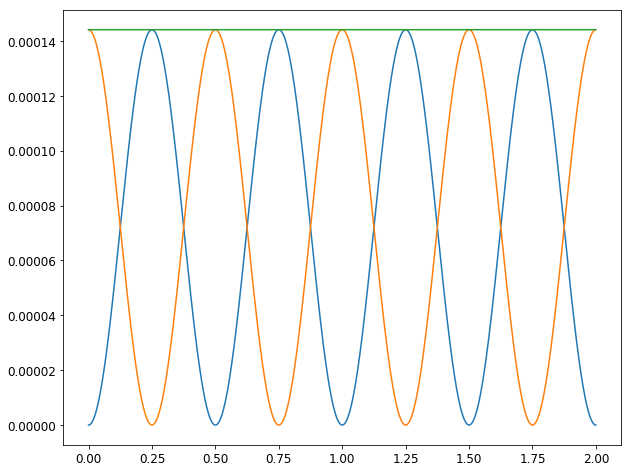

In [4]:
N = 36
A = 0.2
k, m = 1, 1
w_1 = 2 * np.sqrt(k / m) * np.sin(1 * np.pi / (2 * (N + 1)))

delta_t = 0.01
num_iter = int(2 * 2 * np.pi / (w_1 * delta_t))
t_1 = np.arange(num_iter) * delta_t * w_1 / (2 * np.pi)

ret_vals = run_sim_one(N, A, k, m, delta_t, num_iter)

E_k = np.array(ret_vals[2])
E_p = np.array(ret_vals[3])
E_total = E_k[0] + E_p[0]
E_error_1 = np.abs(E_total - (E_k + E_p)) / E_total
E_max_1 = np.max(E_error_1)

plt.plot(t_1, E_k)
plt.plot(t_1, E_p)
plt.plot(t_1, np.ones(len(E_k)) * (E_k[0] + E_p[0]))
plt.show()

In [5]:
delta_t = 0.02
num_iter = int(4 * np.pi / (w_1 * delta_t))
t_2 = np.arange(num_iter) * delta_t * w_1 / (2 * np.pi)

ret_vals = run_sim_one(N, A, k, m, delta_t, num_iter)

E_k = np.array(ret_vals[2])
E_p = np.array(ret_vals[3])
E_total = E_k[0] + E_p[0]
E_error_2 = np.abs(E_total - (E_k + E_p)) / E_total
E_max_2 = np.max(E_error_2)

In [6]:
delta_t = 0.04
num_iter = int(4 * np.pi / (w_1 * delta_t))
t_3 = np.arange(num_iter) * delta_t * w_1 / (2 * np.pi)

ret_vals = run_sim_one(N, A, k, m, delta_t, num_iter)

E_k = np.array(ret_vals[2])
E_p = np.array(ret_vals[3])
E_total = E_k[0] + E_p[0]
E_error_3 = np.abs(E_total - (E_k + E_p)) / E_total
E_max_3 = np.max(E_error_3)

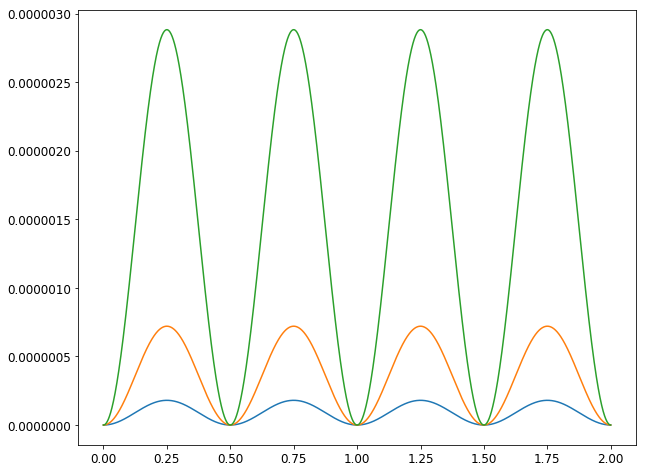

In [7]:
plt.plot(t_1, E_error_1)
plt.plot(t_2, E_error_2)
plt.plot(t_3, E_error_3)
plt.show()

In [8]:
delta_ts = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]
E_maxs = []
for delta_t in delta_ts:
    num_iter = int(4 * np.pi / (w_1 * delta_t))

    ret_vals = run_sim_one(N, A, k, m, delta_t, num_iter)

    E_k = np.array(ret_vals[2])
    E_p = np.array(ret_vals[3])
    E_total = E_k[0] + E_p[0]
    E_error = np.abs(E_total - (E_k + E_p)) / E_total
    E_max = np.max(E_error)
    E_maxs.append(E_max)

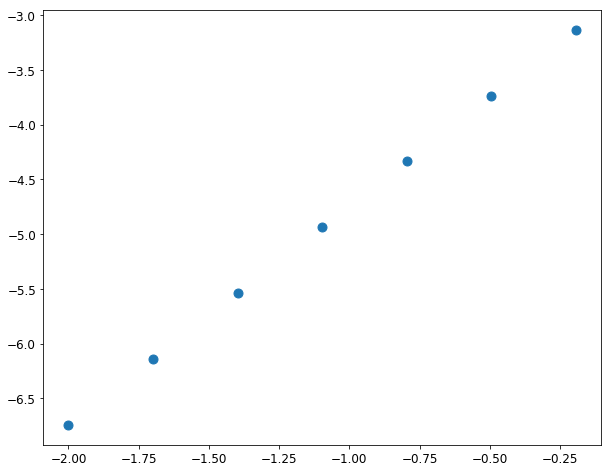

In [9]:
plt.plot(np.log10(delta_ts), np.log10(E_maxs), linestyle='None', marker='o', markersize=9)

plt.show()

In [10]:
N = 100
B = 0.8
sigma = 10
m, k = 1, 1

delta_t = 0.04
num_iter = int(4 * np.pi / (w_1 * delta_t))
t = np.arange(num_iter) * delta_t * w_1 / (2 * np.pi)

ret_vals = run_sim_two(N, B, k, m, sigma, delta_t, num_iter)

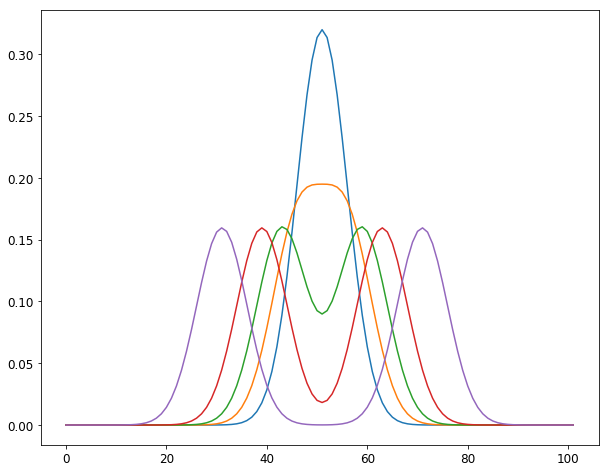

In [11]:
E_l = np.array(ret_vals[4])

plt.plot(E_l[0])
plt.plot(E_l[125])
plt.plot(E_l[200])
plt.plot(E_l[300])
plt.plot(E_l[500])
plt.show()

In [12]:
N = 36
A = 0.5
alpha = 1.25
m, k = 1, 1

delta_t = 0.1
num_iter = int(280 * 2 * np.pi / (w_1 * delta_t))
t = np.arange(num_iter) * delta_t * w_1 / (2 * np.pi)

ret_vals = run_sim_one(N, A, k, m, delta_t, num_iter, alpha=alpha)

x = np.array(ret_vals[0])
v = np.array(ret_vals[1])
E_k = np.array(ret_vals[2])
E_p = np.array(ret_vals[3])
E_l = np.array(ret_vals[4])
E_m = np.array(ret_vals[5])

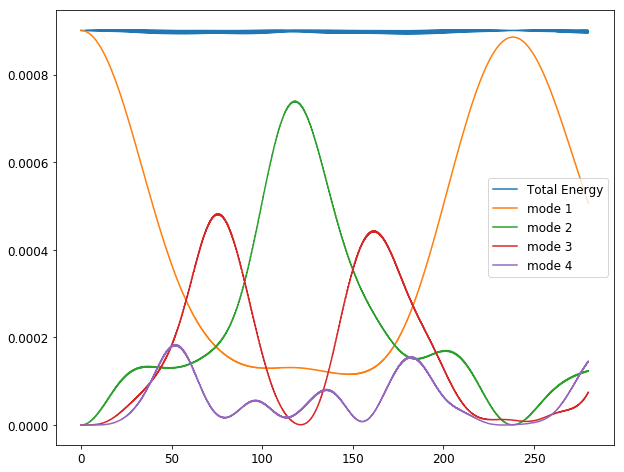

In [13]:
plt.plot(t, E_k + E_p, label='Total Energy')
for i in range(0, 4):
    plt.plot(t, E_m[:, i], label='mode {}'.format(i + 1))
plt.legend()
plt.show()